# Over-sampling using LMNN

In [43]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np
import itertools

from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# Save a nice dark grey as a variable
almost_black = '#262626'

Generate some data with dimension reduction to observed something.

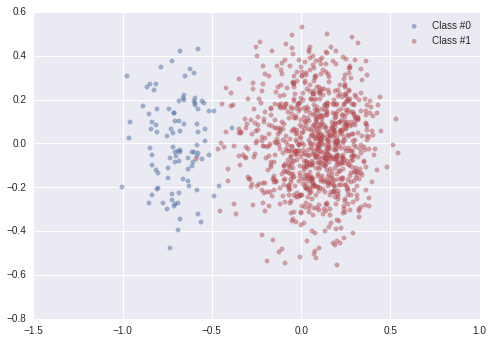

In [44]:
# Generate some data
x, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9],
                           n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1,
                           n_samples=1000, random_state=10)

x = normalize(x)

# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components = 2)

# Fit and transform x to visualise inside a 2D feature space
x_vis = pca.fit_transform(x)

# Plot the original data
# Plot the two classes
palette = sns.color_palette()
plt.scatter(x_vis[y==0, 0], x_vis[y==0, 1], label="Class #0", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
plt.scatter(x_vis[y==1, 0], x_vis[y==1, 1], label="Class #1", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)

plt.legend()
plt.show()

Compute the LMNN for each sample of the minority class

In [47]:
from collections import Counter

# Compute the classes representation
stat_class = Counter(y)
# Find the minority class key
label_min_class = min(stat_class, key=stat_class.get)
# Save the sample index of this class
idx_min_class = np.ravel(np.nonzero(y == 0))

from sklearn.neighbors import NearestNeighbors

# Create an object NN only for the minority class
min_class_NN = NearestNeighbors(n_neighbors=11, n_jobs=-1)
min_class_NN.fit(x[idx_min_class, :], y[idx_min_class])

# Create an object NN for the whole dataset
data_NN = NearestNeighbors(n_neighbors=3, n_jobs=-1)
data_NN.fit(x, y)

# Compute all the distance of the k-NN on the minority class on the original data
dist, ind = min_class_NN.kneighbors()
# Find the maximum distance
max_dist = np.max(dist, axis=1)

# Now find the samples to consider with the distance extracted using only the minority class
# We need to loop since that the distance is changing
s_considers = []
for s, d in zip(x[idx_min_class], max_dist):
    dist, ind = data_NN.radius_neighbors(X=np.atleast_2d(s), radius=d)
    s_considers.append(ind)
    
from metric_learn import LMNN

cov_mat = []
for s in s_considers:
    # Extract the interesting data
    x_s = x[s[0], :]
    y_s = y[s[0]]
    
    # Check if there is any imposter
    tmp = Counter(y_s)
    
    # Fit the LMNN for these data
    s_lmnn = LMNN(k=len(s[0]))
    s_lmnn.fit(x_s, y_s)
    # Store the covariance matrix
    cov_mat.append(numpy.dot(s_lmnn.L.T, s_lmnn.L) )

IndexError: list index out of range

In [45]:
a = LMNN()
a.fit(x,y)

In [48]:
print tmp

Counter({0: 12})
